In [57]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import warnings


warnings.filterwarnings("ignore")

In [58]:
#Create a Pandas dataframe from .csv file
msft_df = pd.read_csv("/content/sample_data/MSFT_Historical_Data.csv")
print(msft_df.shape)

(2515, 6)


In [59]:
#Check for null entries
print(msft_df.isnull())
if msft_df.isnull().values.any():
    print("DataFrame has empty entries")
else:
    print("DataFrame does not have empty entries")

       Date  Close/Last  Volume   Open   High    Low
0     False       False   False  False  False  False
1     False       False   False  False  False  False
2     False       False   False  False  False  False
3     False       False   False  False  False  False
4     False       False   False  False  False  False
...     ...         ...     ...    ...    ...    ...
2510  False       False   False  False  False  False
2511  False       False   False  False  False  False
2512  False       False   False  False  False  False
2513  False       False   False  False  False  False
2514  False       False   False  False  False  False

[2515 rows x 6 columns]
DataFrame does not have empty entries


In [60]:
print(msft_df.sample(10))

            Date Close/Last    Volume     Open       High        Low
1231  02/20/2020    $184.42  36862380  $186.95    $187.25    $181.10
2019  12/30/2016     $62.14  25575720   $62.96     $62.99     $62.03
1253  01/17/2020    $167.10  34371660  $167.42  $167.4675    $165.43
1394  06/27/2019    $134.15  16557480  $134.14    $134.71    $133.51
1551  11/08/2018    $111.75  25479410  $111.80    $112.21    $110.91
1051  11/04/2020    $216.39  42311780  $214.02    $218.32  $212.4185
1900  06/22/2017     $70.26  22602120   $70.54     $70.59     $69.71
1683  05/03/2018     $94.07  31071660   $92.96    $94.925     $92.45
1129  07/16/2020    $203.92  29940650  $205.40    $205.70    $202.31
558   10/20/2022    $236.15  21811020  $235.77    $241.31    $234.87


In [61]:
#Display data types of dataframe
msft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2515 non-null   object
 1   Close/Last  2515 non-null   object
 2   Volume      2515 non-null   int64 
 3   Open        2515 non-null   object
 4   High        2515 non-null   object
 5   Low         2515 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.0+ KB


In [62]:
#Convert strings ($) and dates to usable data
msft_df['Date'] = pd.to_datetime(msft_df['Date'])
msft_df['Close/Last'] = msft_df['Close/Last'].str.replace('$', '').astype(float)
msft_df['Open'] = msft_df['Open'].str.replace('$', '').astype(float)
msft_df['High'] = msft_df['High'].str.replace('$', '').astype(float)
msft_df['Low'] = msft_df['Low'].str.replace('$', '').astype(float)

msft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2515 non-null   datetime64[ns]
 1   Close/Last  2515 non-null   float64       
 2   Volume      2515 non-null   int64         
 3   Open        2515 non-null   float64       
 4   High        2515 non-null   float64       
 5   Low         2515 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.0 KB


In [63]:
print(msft_df.sample(5))

           Date  Close/Last    Volume    Open      High      Low
2274 2015-12-28       55.95  21704030   55.35   55.9500   54.980
1001 2021-01-19      216.44  30480860  213.75  216.9800  212.630
1017 2020-12-23      221.02  18699640  223.11  223.5589  220.800
1402 2019-06-17      132.85  14517790  132.63  133.7300  132.530
1674 2018-05-16       97.15  17371190   97.36   97.4000   96.615


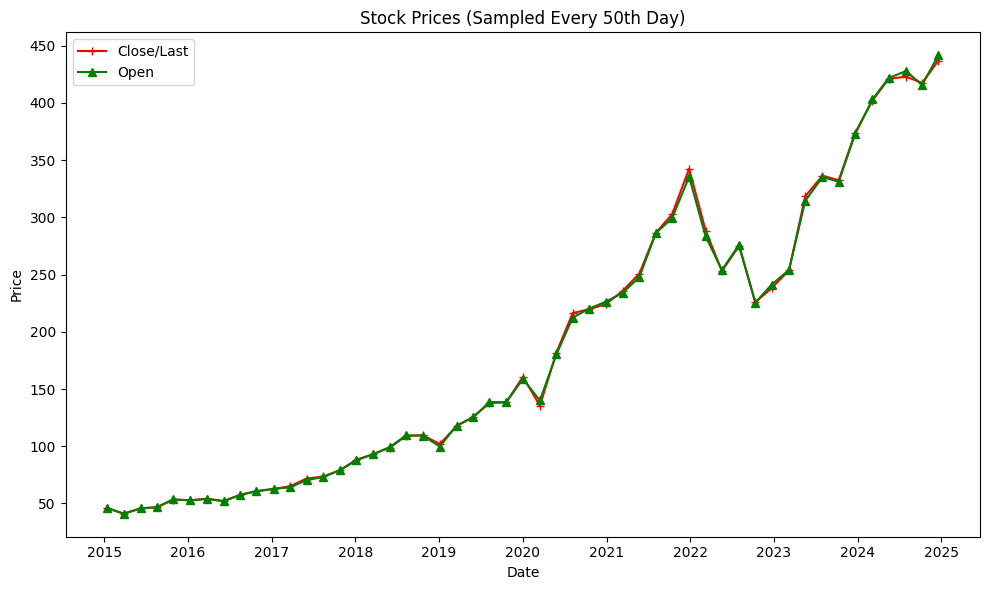

In [64]:
#Reversing order of data so that training is at 80% (Starting from 2013)
dataframe = msft_df.iloc[::-1].reset_index(drop = True)
#Sampling every 50th row of data
sampled_data = dataframe.iloc[::50]

plt.figure(figsize=(10, 6))
plt.plot(sampled_data['Date'], sampled_data['Close/Last'], color="r", label="Close/Last", marker="+")
plt.plot(sampled_data['Date'], sampled_data['Open'], color="g", label="Open", marker="^")

plt.title("Stock Prices (Sampled Every 50th Day)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

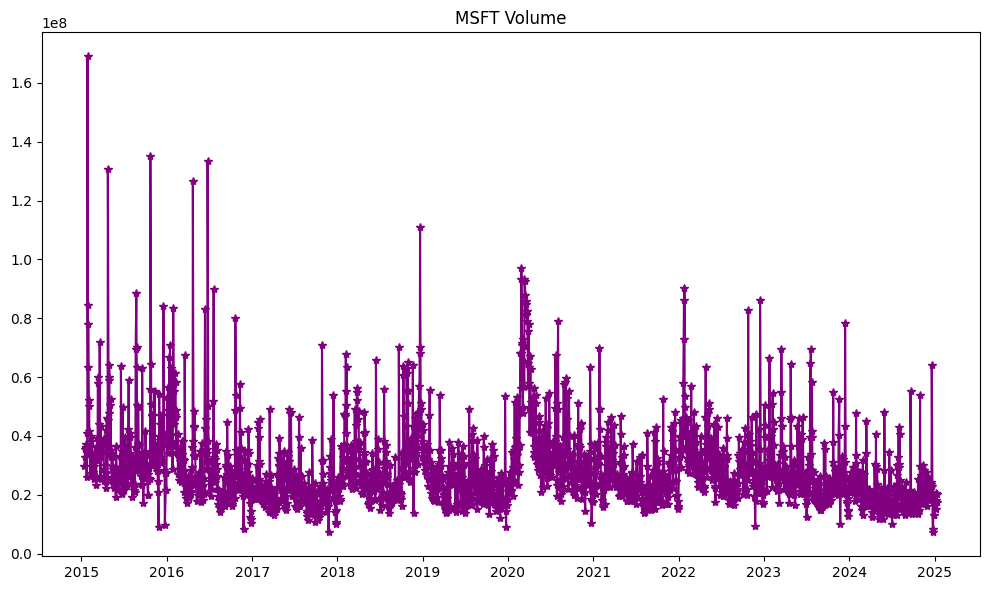

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(dataframe['Date'], dataframe['Volume'], c='purple', marker='*')
plt.title("MSFT Volume")
plt.tight_layout()

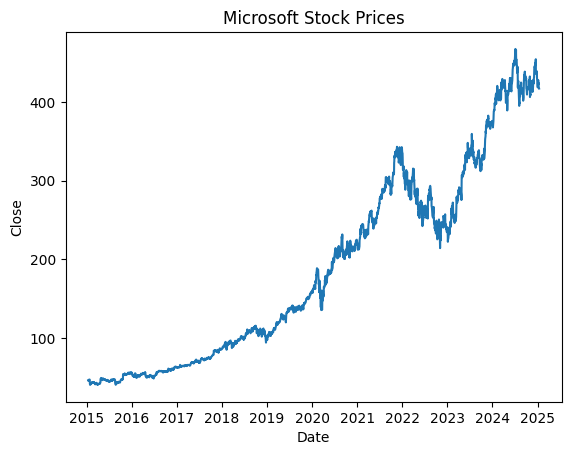

In [66]:
plt.plot(dataframe['Date'],dataframe['Close/Last'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Microsoft Stock Prices")
plt.show()

Using more parameters to train a model can lead to unnecessary complexity and overfitting, and might include data that isn't useful.


In [67]:
close_data = dataframe[['Close/Last', 'Volume', 'Open', 'High', 'Low']]
close_data.head()
dataset = close_data.values
training = int(np.ceil(len(dataset) * 0.80))

#Scaling all parameters to between 0 and 1, large swings
#in data size can have a negative effect on the model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, :]) #
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [68]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32, activation='linear'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 60, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
#MSE loss function is the standard for stocks
#Huber loss function is useful when data has huge swings (strange outliers)
#adam (Adaptive Moment Estimation) dynamically adjusts learning rates
#model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
model.compile(optimizer='adam', loss='mse')
history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0140
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013


In [70]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)

# predict the testing data
predictions = model.predict(x_test)
predictions = predictions.reshape(-1, 1)
predictions = np.hstack([predictions, np.zeros((predictions.shape[0], dataset.shape[1] - 1))])
predictions = scaler.inverse_transform(predictions)
predictions = predictions[:, 0]

y_test_close = y_test[:, 0]

# evaluation metrics
mse = np.mean(((predictions - y_test_close) ** 2))
print("RMSE", np.sqrt(mse))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
RMSE 15.615387158479946


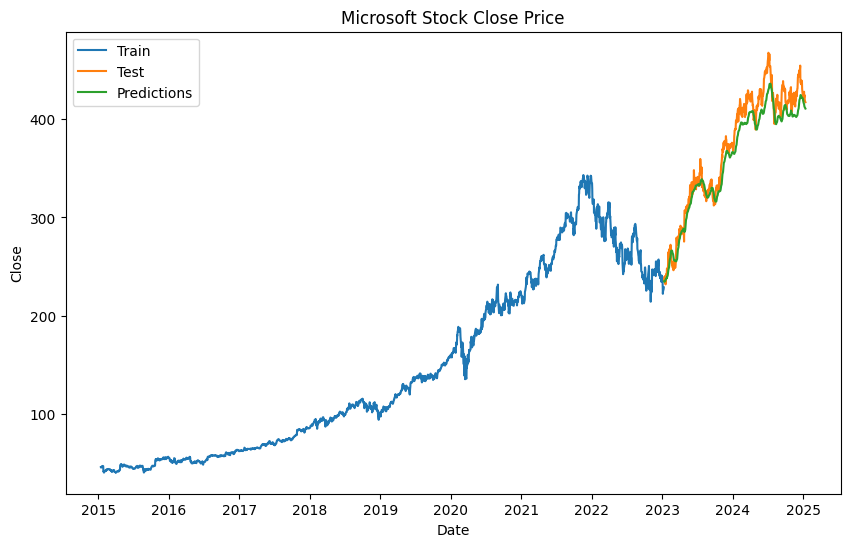

In [71]:
train = dataframe[:training]
test = dataframe[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 6))
plt.plot(train['Date'], train['Close/Last'])
plt.plot(test['Date'], test[['Close/Last', 'Predictions']])
plt.title('Microsoft Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

Now I will attempt to predict the next 60 days of stock movement, whereas earlier we were feeding the model real stock prices, in this instance we will create a feedback loop that uses the models past predictions to create future predictions

In [72]:
# Start with the last 120 days of data
last_120_days = scaled_data[-120:, :]
future_predictions = []

last_date = dataframe['Date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 61)]

# Predict the next 60 days
with tqdm(total=60, desc="Generating Predictions") as pbar:
  for _ in range(60):
    # Reshape for prediction (1 sample, 60 time steps, features)
    x_input = last_120_days.reshape(1, last_120_days.shape[0], last_120_days.shape[1])

    # Predict the next value
    pred = model.predict(x_input, verbose=0)

    # Save the prediction
    future_predictions.append(pred[0, 0])  # Assuming a single feature prediction

    # Update the last 60 days by appending the prediction
    pred_scaled = np.hstack([pred, np.zeros((1, scaled_data.shape[1] - 1))])  # Pad if multiple features
    last_120_days = np.vstack([last_120_days[1:], pred_scaled])  # Slide window forward

    pbar.update(1)

# Inverse transform the predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = np.hstack([future_predictions, np.zeros((future_predictions.shape[0], scaled_data.shape[1] - 1))])
future_predictions = scaler.inverse_transform(future_predictions)
future_predictions = future_predictions[:, 0]  # Extract the predicted feature

future_df = pd.DataFrame({
    'Date': future_dates,
    'Predictions': future_predictions
})

Generating Predictions: 100%|██████████| 60/60 [00:03<00:00, 15.73it/s]


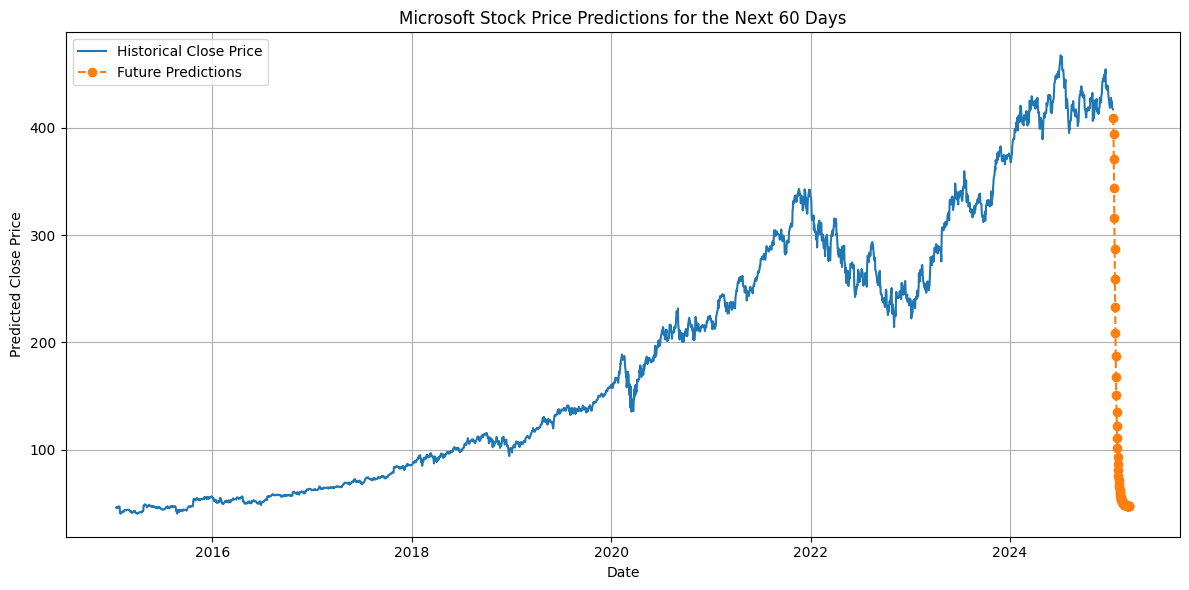

In [73]:
# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(dataframe['Date'], dataframe['Close/Last'], label='Historical Close Price')
plt.plot(future_df['Date'], future_df['Predictions'], label='Future Predictions', linestyle='--', marker='o')
plt.title('Microsoft Stock Price Predictions for the Next 60 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

During the first prediction we use real data to predict the next day of the Closing value of the stock, but in this section we are creating the data, small feedback errors in data predicted cause the model to predict a total collapse in value